This notebook is for analyzing depth-averaged momentum budget using MOM6 output. The effects of time-averaging and spatial filtering are discussed.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
import filter
from dask.diagnostics import ProgressBar
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)

client

<Client: 'tcp://127.0.0.1:43083' processes=4 threads=16, memory=406.01 GB>

In [2]:
# Functions for plotting

def plot_map(ax, da, vmin=-999, vmax=999, vstep=1,
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.6)
    cb.ax.tick_params(labelsize=12)

    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

def plot_map_SO(ax, da, vmin=-999, vmax=999, vstep=1,
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.6)
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent([-180, 180, -82, -28], crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

## Effect of temporal averaging on momentum budget terms

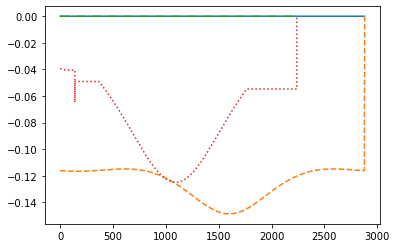

In [21]:
plt.plot(ds_full.xh.values - ds_grid.xh.values, '-')
plt.plot(ds_full.xq.values - ds_grid.xq.values, '--')
plt.plot(ds_full.yh.values - ds_grid.yh.values,'-.')
plt.plot(ds_full.yq.values - ds_grid.yq.values,':')
#plt.plot(ds_full.xq, '--')

In [10]:
path = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20201120/CM4_piControl_c192_OM4p125/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/"
ds_full = xr.open_mfdataset(path + "ocean_monthly.000101-000512*.nc")

#ds_full = ds_full.isel(xq = slice(0,2880), yq=slice(0,2240))

ppdir1 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20201120/CM4_piControl_c192_OM4p125/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/"
ds_grid = xr.open_dataset(ppdir1 + "ocean_monthly.static.nc")
#ds_grid = ds_grid.isel(xq = slice(0,2880), yq=slice(0,2240))

#ds_grid = xr.open_dataset("/work/Hemant.Khatri/MOM6_idealised/MOM_budget/OM125_monthly.nc")

#ds_full = xr.merge([ds_full, ds_grid]) 
## merge does work because there are issues in xq, yq arrays in static file.

ds_full['geolon'] = xr.DataArray(ds_grid['geolon'].values,dims=['yh','xh'])
ds_full['geolat'] = xr.DataArray(ds_grid['geolat'].values,dims=['yh','xh'])
ds_full['geolon_u'] = xr.DataArray(ds_grid['geolon_u'].values,dims=['yh','xq'])
ds_full['geolat_u'] = xr.DataArray(ds_grid['geolat_u'].values,dims=['yh','xq'])
ds_full['geolon_v'] = xr.DataArray(ds_grid['geolon_v'].values,dims=['yq','xh'])
ds_full['geolat_v'] = xr.DataArray(ds_grid['geolat_v'].values,dims=['yq','xh'])
ds_full['geolon_c'] = xr.DataArray(ds_grid['geolon_c'].values,dims=['yq','xq'])
ds_full['geolat_c'] = xr.DataArray(ds_grid['geolat_c'].values,dims=['yq','xq'])

ds_full = ds_full.assign_coords({'geolon': ds_full['geolon'], 'geolat': ds_full['geolat'], 
                      'geolon_u': ds_full['geolon_u'], 'geolat_u': ds_full['geolat_u'],
                      'geolon_v': ds_full['geolon_v'], 'geolat_v': ds_full['geolat_v'],
                      'geolon_c': ds_full['geolon_c'], 'geolat_c': ds_full['geolat_c']})

ds_full = ds_full.isel(xq = slice(0,2880), yq=slice(0,2240)) # to avoid nan values in geolat, geolon
print(ds_full)

<xarray.Dataset>
Dimensions:                 (nv: 2, time: 60, xh: 2880, xq: 2880, yh: 2240, yq: 2240, zi: 76)
Coordinates:
  * xq                      (xq) float64 -298.6 -298.5 -298.4 ... 61.12 61.23
  * yq                      (yq) float64 -83.64 -83.6 -83.56 ... 89.89 89.95
  * xh                      (xh) float64 -298.6 -298.5 -298.4 ... 61.16 61.28
  * yh                      (yh) float64 -83.62 -83.58 -83.54 ... 89.92 89.97
  * nv                      (nv) float64 1.0 2.0
  * time                    (time) object 0001-01-16 12:00:00 ... 0005-12-16 ...
  * zi                      (zi) float64 0.0 2.0 4.0 ... 3.722e+03 6.5e+03
    geolon                  (yh, xh) float32 -298.59146 -298.4752 ... 59.99987
    geolat                  (yh, xh) float32 -82.456726 -82.4552 ... 64.05896
    geolon_u                (yh, xq) float32 -298.53333 -298.41705 ... 60.0
    geolat_u                (yh, xq) float32 -82.45596 -82.45444 ... 64.03161
    geolon_v                (yq, xh) float32 -298

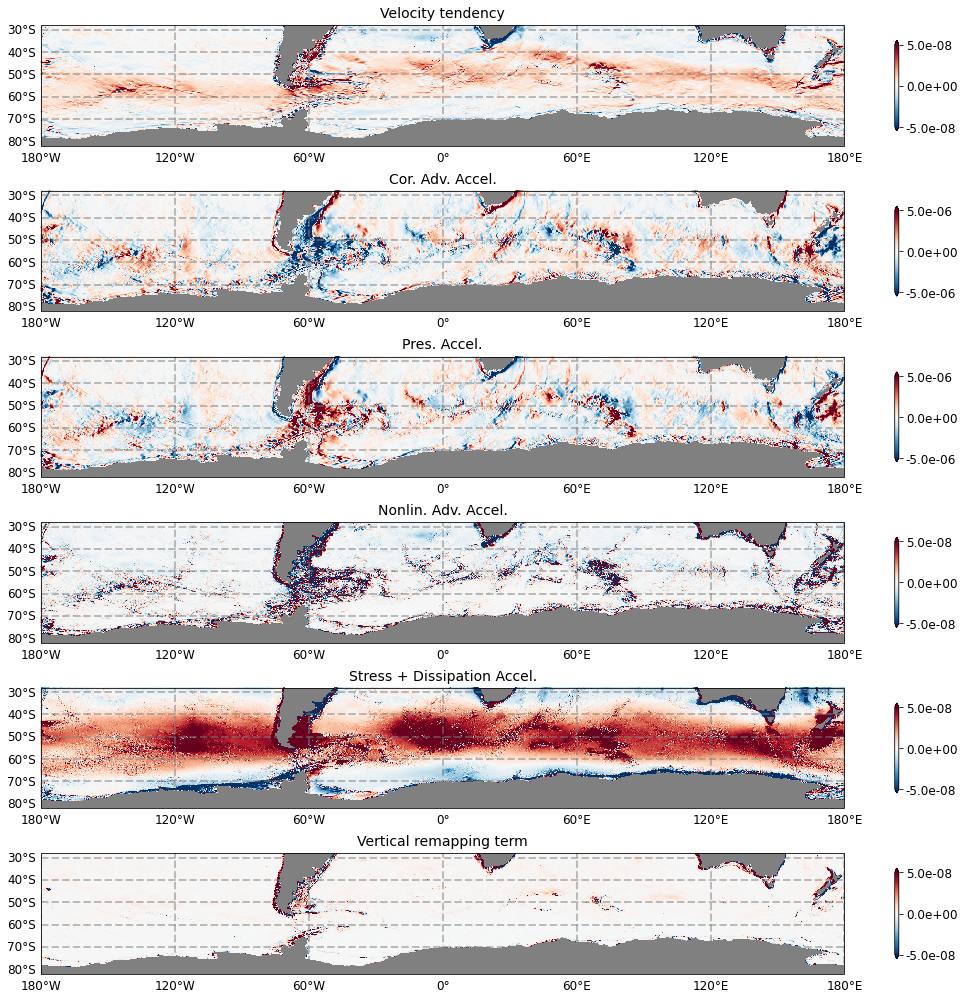

In [15]:
# Monthly-mean data

max_r = 0.5e-5

ds = ds_full.isel(time=0)

grid = plt.GridSpec(6, 1, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,18])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_dudt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Velocity tendency')

ax = fig.add_subplot(grid[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_CAu_2d'] - ds['hf_gKEu_2d'] - ds['hf_rvxv_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Cor. Adv. Accel.')

ax = fig.add_subplot(grid[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_PFu_2d']+ds['hf_u_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Pres. Accel.')

ax = fig.add_subplot(grid[3, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_gKEu_2d'] + ds['hf_rvxv_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Nonlin. Adv. Accel.')

ax = fig.add_subplot(grid[4, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_du_dt_visc_2d'] + ds['hf_diffu_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Stress + Dissipation Accel.')

tmp = ds['hf_dudt_2d']-ds['hf_CAu_2d']-ds['hf_PFu_2d']-ds['hf_diffu_2d']-ds['hf_du_dt_visc_2d']-ds['hf_u_BT_accel_2d']
ax = fig.add_subplot(grid[5, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, tmp, vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Vertical remapping term')

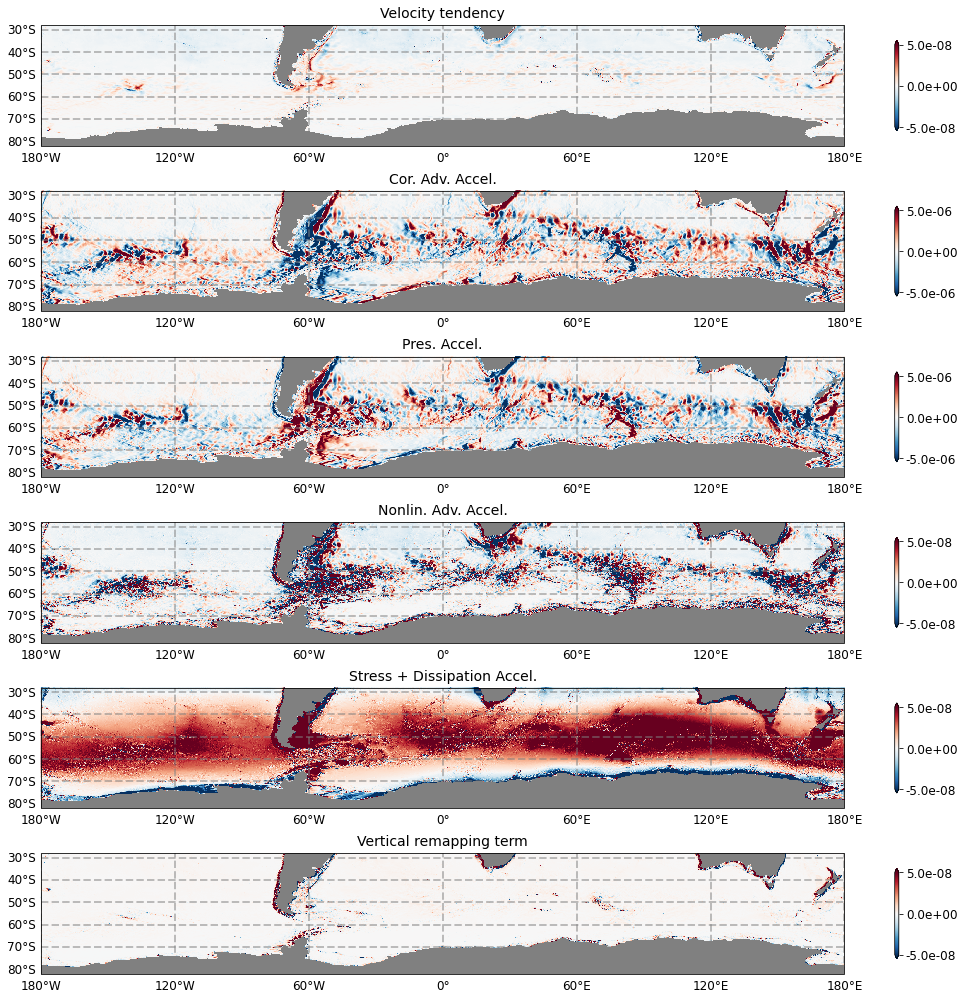

In [14]:
# Yearly-mean data

max_r = 0.5e-5

ds = ds_full.isel(time=slice(0,12)).mean('time')

grid = plt.GridSpec(6, 1, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,18])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_dudt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Velocity tendency')

ax = fig.add_subplot(grid[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_CAu_2d'] - ds['hf_gKEu_2d'] - ds['hf_rvxv_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Cor. Adv. Accel.')

ax = fig.add_subplot(grid[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_PFu_2d']+ds['hf_u_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Pres. Accel.')

ax = fig.add_subplot(grid[3, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_gKEu_2d'] + ds['hf_rvxv_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Nonlin. Adv. Accel.')

ax = fig.add_subplot(grid[4, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_du_dt_visc_2d'] + ds['hf_diffu_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Stress + Dissipation Accel.')

tmp = ds['hf_dudt_2d']-ds['hf_CAu_2d']-ds['hf_PFu_2d']-ds['hf_diffu_2d']-ds['hf_du_dt_visc_2d']-ds['hf_u_BT_accel_2d']
ax = fig.add_subplot(grid[5, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, tmp, vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Vertical remapping term')

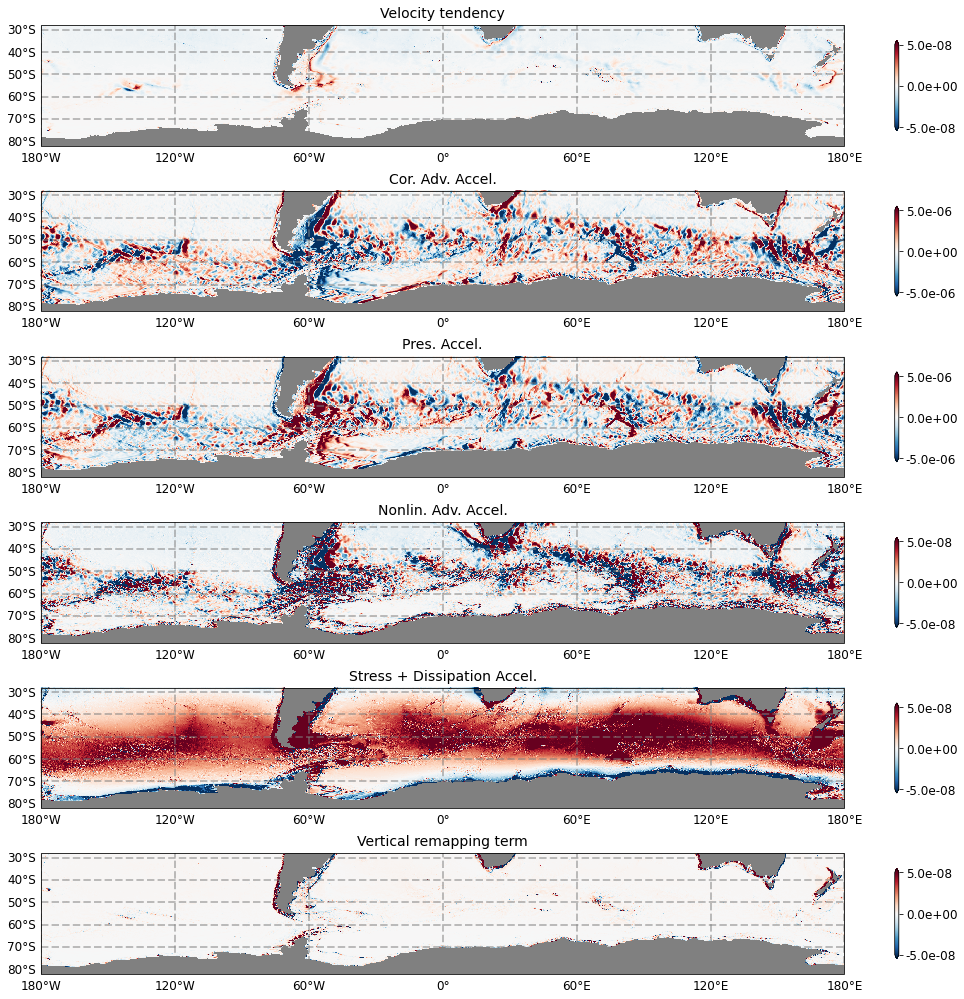

In [16]:
# 5 year-mean data

max_r = 0.5e-5

ds = ds_full.mean('time')

grid = plt.GridSpec(6, 1, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,18])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_dudt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Velocity tendency')

ax = fig.add_subplot(grid[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_CAu_2d'] - ds['hf_gKEu_2d'] - ds['hf_rvxv_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Cor. Adv. Accel.')

ax = fig.add_subplot(grid[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_PFu_2d']+ds['hf_u_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Pres. Accel.')

ax = fig.add_subplot(grid[3, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_gKEu_2d'] + ds['hf_rvxv_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Nonlin. Adv. Accel.')

ax = fig.add_subplot(grid[4, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, ds['hf_du_dt_visc_2d'] + ds['hf_diffu_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Stress + Dissipation Accel.')

tmp = ds['hf_dudt_2d']-ds['hf_CAu_2d']-ds['hf_PFu_2d']-ds['hf_diffu_2d']-ds['hf_du_dt_visc_2d']-ds['hf_u_BT_accel_2d']
ax = fig.add_subplot(grid[5, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_map_SO(ax, tmp, vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Vertical remapping term')

## Efffects of spatial filtering

In [3]:
def apply_gaussian_filter(field,wetMask,NL_g,sL_g,NB_g,sB_g):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_g):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_g[i])*tempL # Update filtered field
    for i in range(NB_g): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_g[i])/np.abs(sB_g[i])**2)*tempL + (1/np.abs(sB_g[i])**2)*tempB
        
    return fieldBar

def simple_Laplacian(phi,wetMask):
    np = _get_array_module(phi)

    out = phi.copy()
    out = np.nan_to_num(out) 
    out = wetMask * out 
    
    fac = (np.roll(wetMask, -1, axis=-1) 
            + np.roll(wetMask, 1, axis=-1) 
            + np.roll(wetMask, -1, axis=-2) 
            + np.roll(wetMask, 1, axis=-2)  
    )
        
    out = (- fac * out
            + np.roll(out, -1, axis=-1) 
            + np.roll(out, 1, axis=-1) 
            + np.roll(out, -1, axis=-2) 
            + np.roll(out, 1, axis=-2)
    )
        
    out = wetMask * out
    return out

try:
    from cupy import get_array_module as _get_array_module
except ImportError:
    import numpy as np

    def _get_array_module(*args):
        return np

In [4]:
ds = xr.open_dataset("/work/Hemant.Khatri/MOM6_idealised/MOM_budget/OM125_monthly.nc")

print(ds)

<xarray.Dataset>
Dimensions:           (nv: 2, xh: 2880, xq: 2880, yh: 2240, yq: 2240)
Coordinates:
  * nv                (nv) float64 1.0 2.0
    time              object ...
  * xq                (xq) float64 -298.5 -298.4 -298.3 ... 61.12 61.23 61.35
  * yh                (yh) float64 -83.62 -83.58 -83.54 ... 89.86 89.92 89.97
  * xh                (xh) float64 -298.6 -298.5 -298.4 ... 61.05 61.16 61.28
  * yq                (yq) float64 -83.6 -83.56 -83.52 ... 89.89 89.95 90.0
    geolat            (yh, xh) float32 ...
    geolat_c          (yq, xq) float32 ...
    geolat_u          (yh, xq) float32 ...
    geolat_v          (yq, xh) float32 ...
    geolon            (yh, xh) float32 ...
    geolon_c          (yq, xq) float32 ...
    geolon_u          (yh, xq) float32 ...
    geolon_v          (yq, xh) float32 ...
Data variables:
    average_DT        timedelta64[ns] ...
    average_T1        object ...
    average_T2        object ...
    hf_CAu_2d         (yh, xq) float32 ...
   

In [5]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

topo_x = - grid.diff(ds.deptho * ds.dyt, 'X', boundary='fill') / ds.areacello_cu # negative sign in gradient calculation as we are using ocean depth
tau_f = topo_x * grid.interp(ds.pbo, 'X',  boundary='fill') # first interpolate pbo on u points

# Laplacian steps: 13; # Biharmonic steps: 1


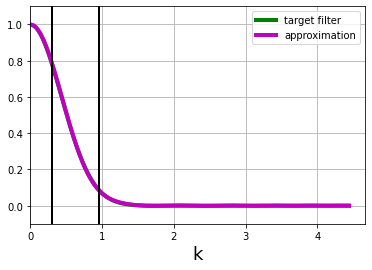

In [6]:
# Guassian Filter set 

filter_fac_1Deg = 8 # 1/8 --> 1 Deg

Lf_g_1Deg = filter_fac_1Deg/np.sqrt(6) 
N_g_1Deg=15
NL_g_1Deg, sL_g_1Deg, NB_g_1Deg, sB_g_1Deg = filter.filterSpec(N_g_1Deg, 1, Lf_g_1Deg, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g_1Deg) + '; # Biharmonic steps: ' + str(NB_g_1Deg))

In [10]:
dims = ['yh', 'xq']

dataBar = tau_f.copy() # Initialize the filtering process
#dataBar = ds.hf_CAu_2d.copy()
dataBar = dataBar * ds['areacello_cu']

dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_u'], NL_g_1Deg, sL_g_1Deg, NB_g_1Deg, sB_g_1Deg, 
                         input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                         output_dtypes=[dataBar.dtype], dask='parallelized')

#dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
dataBar = xr.where(ds['wet_u'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['areacello_cu'] # divide by cell area    
            
tau_f_1Deg = dataBar.copy()

# Laplacian steps: 30; # Biharmonic steps: 0


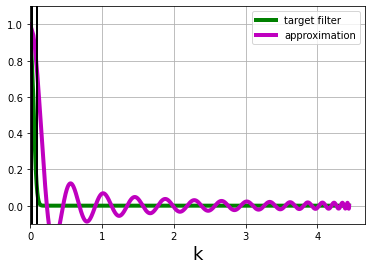

In [19]:
# Guassian Filter set 
# Note - Increasing N_g to large number makes the filtering worse as a lot of noise appears in the filtered field

filter_fac_10Deg = 80 # 1/8 --> 10 Deg

Lf_g_10Deg = filter_fac_10Deg/np.sqrt(6) 
N_g_10Deg=30
NL_g_10Deg, sL_g_10Deg, NB_g_10Deg, sB_g_10Deg = filter.filterSpec(N_g_10Deg, 1, Lf_g_10Deg, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g_10Deg) + '; # Biharmonic steps: ' + str(NB_g_10Deg))

In [20]:
dims = ['yh', 'xq']

dataBar = tau_f.copy() # Initialize the filtering process
#dataBar = ds.hf_CAu_2d.copy()
dataBar = dataBar * ds['areacello_cu']

dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_u'], NL_g_10Deg, sL_g_10Deg, NB_g_10Deg, sB_g_10Deg, 
                         input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                         output_dtypes=[dataBar.dtype], dask='parallelized')

#dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
dataBar = xr.where(ds['wet_u'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['areacello_cu'] # divide by cell area    
            
tau_f_10Deg = dataBar.copy()

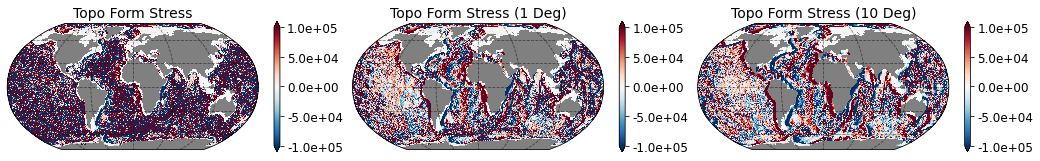

In [22]:
max_r = 1.e5

grid = plt.GridSpec(1, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,4])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tau_f, vmin=-max_r, vmax=max_r, vstep=2.e2*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Topo Form Stress')

ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tau_f_1Deg, vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Topo Form Stress (1 Deg)')

ax = fig.add_subplot(grid[0, 2], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tau_f_10Deg, vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Topo Form Stress (10 Deg)')

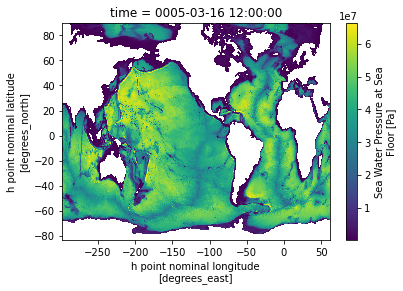

In [9]:
ds.pbo.plot()

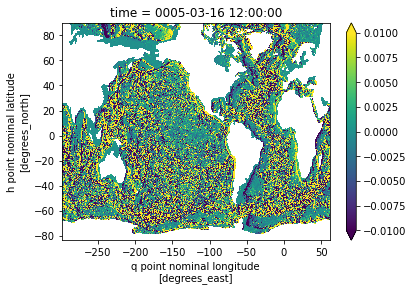

In [11]:
topo_x.plot(vmin = -.01, vmax=0.01)

In [17]:
ds.close()
ds_full.close()
client.close()
cluster.close()

### 1/4 deg run 5-year average data 

In [3]:
# Filter set

def apply_gaussian_filter(field,wetMask,NL_g,sL_g,NB_g,sB_g):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_g):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_g[i])*tempL # Update filtered field
    for i in range(NB_g): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_g[i])/np.abs(sB_g[i])**2)*tempL + (1/np.abs(sB_g[i])**2)*tempB
        
    return fieldBar

def apply_taper_filter(field,wetMask,NL_t,sL_t,NB_t,sB_t):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_t):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_t[i])*tempL # Update filtered field
    for i in range(NB_t): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_t[i])/np.abs(sB_t[i])**2)*tempL + (1/np.abs(sB_t[i])**2)*tempB
        
    return fieldBar

def simple_Laplacian(phi,wetMask):
    np = _get_array_module(phi)

    out = phi.copy()
    out = np.nan_to_num(out) 
    out = wetMask * out 
    
    fac = (np.roll(wetMask, -1, axis=-1) 
            + np.roll(wetMask, 1, axis=-1) 
            + np.roll(wetMask, -1, axis=-2) 
            + np.roll(wetMask, 1, axis=-2)  
    )
        
    out = (- fac * out
            + np.roll(out, -1, axis=-1) 
            + np.roll(out, 1, axis=-1) 
            + np.roll(out, -1, axis=-2) 
            + np.roll(out, 1, axis=-2)
    )
        
    out = wetMask * out
    return out

try:
    from cupy import get_array_module as _get_array_module
except ImportError:
    import numpy as np

    def _get_array_module(*args):
        return np

# Laplacian steps: 16; # Biharmonic steps: 2


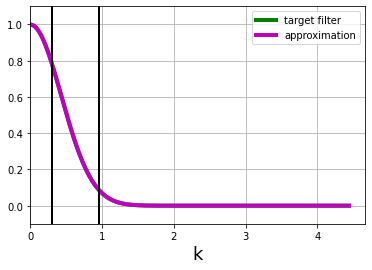

In [4]:
# Set Filter

# Guassian Filter set 

filter_fac = 8 # 1/4 --> 2 Deg

Lf_g = filter_fac/np.sqrt(6) 
N_g = 20
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

In [5]:
path = "/archive/Hemant.Khatri/MOM_Budget/OM4p25/"

filelist = glob.glob(path + "OM4p25*.nc")
filelist.sort()

ds = []
for i in range(2,12):
    
    d = xr.open_dataset(filelist[i])
    ds.append(d)
    
ds = xr.concat(ds, dim='tim')
ds = ds.chunk({'tim': 1})

print(ds)

<xarray.Dataset>
Dimensions:             (tim: 10, xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * xh                  (xh) float64 -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * yh                  (yh) float64 -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
  * xq                  (xq) float64 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yq                  (yq) float64 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
Dimensions without coordinates: tim
Data variables:
    hf_CAu_2d           (tim, yh, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    hf_CAv_2d           (tim, yq, xh) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    hf_PFu_2d           (tim, yh, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    hf_PFv_2d           (tim, yq, xh) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    hf_diffu_2d         (tim, yh, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    hf_diffv_2d     

In [7]:
%%time

ds_g = xr.Dataset() # new xarray dataset for Gaussian-filtered fields with Fixed (coarsening) Factor

fldlist = ['hf_dudt_2d','hf_CAu_2d','hf_PFu_2d','hf_u_BT_accel_2d', 'hf_du_dt_visc_2d', 'hf_diffu_2d', 'ubt_dt']
dims = ['yh', 'xq']

tim_j = 0

# Gaussian filter
for fld in fldlist: 
    
    dataBar = ds[fld].isel(tim=tim_j).load().copy()
        
    dataBar = dataBar * ds['areacello_cu'].isel(tim=0).load()

    dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_u'].isel(tim=0).load(), NL_g, sL_g, NB_g, sB_g, 
                             input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                             output_dtypes=[dataBar.dtype], dask='parallelized')

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(ds['wet_u'].isel(tim=0).load(),dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds['areacello_cu'].isel(tim=0) # divide by cell area    

    ds_g[fld] = (dataBar.copy()).assign_coords({'geolat_u': ds['geolat_u'].isel(tim=0), 
                                                   'geolon_u': ds['geolon_u'].isel(tim=0)})

CPU times: user 7.53 s, sys: 6.24 s, total: 13.8 s
Wall time: 13.5 s


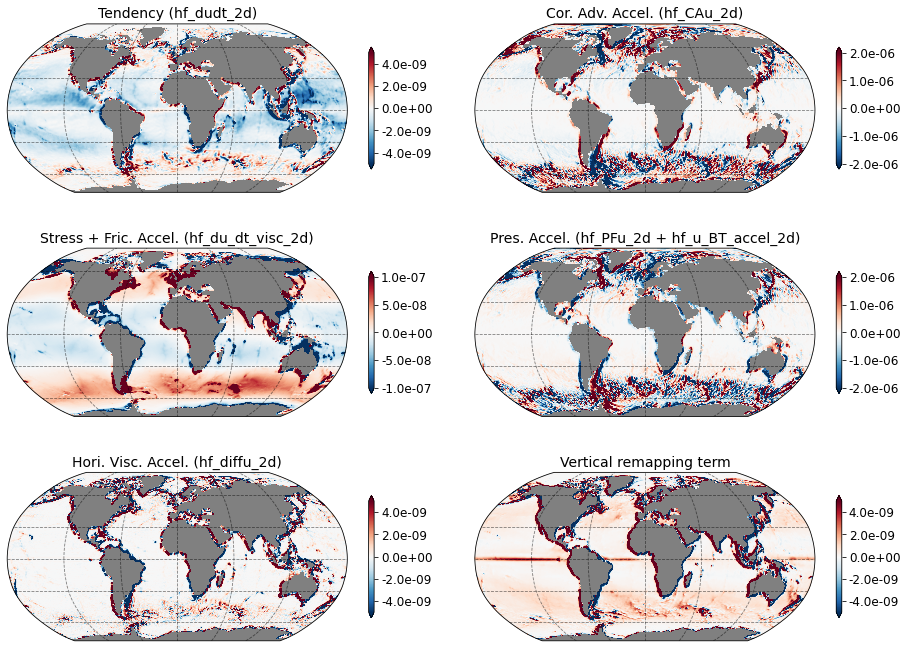

In [13]:
# Zonal Momentum budget (units are in m/s2)
max_r = 0.2e-5

grid = plt.GridSpec(3, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[16,12])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds_g['hf_dudt_2d'], vmin=-0.25e-2*max_r, vmax=0.25e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Tendency (hf_dudt_2d)')

ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds_g['hf_CAu_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Cor. Adv. Accel. (hf_CAu_2d)')

ax = fig.add_subplot(grid[1, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds_g['hf_PFu_2d']+ds_g['hf_u_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Pres. Accel. (hf_PFu_2d + hf_u_BT_accel_2d)')

ax = fig.add_subplot(grid[1, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds_g['hf_du_dt_visc_2d'], vmin=-0.5e-1*max_r, vmax=0.5e-1*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Stress + Fric. Accel. (hf_du_dt_visc_2d)')

ax = fig.add_subplot(grid[2, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds_g['hf_diffu_2d'], vmin=-0.25e-2*max_r, vmax=0.25e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Hori. Visc. Accel. (hf_diffu_2d)')

tmp = ds_g['hf_dudt_2d']-ds_g['hf_CAu_2d']-ds_g['hf_PFu_2d']-ds_g['hf_diffu_2d']-ds_g['hf_du_dt_visc_2d']-ds_g['hf_u_BT_accel_2d']
ax = fig.add_subplot(grid[2, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-0.25e-2*max_r, vmax=0.25e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Vertical remapping term')

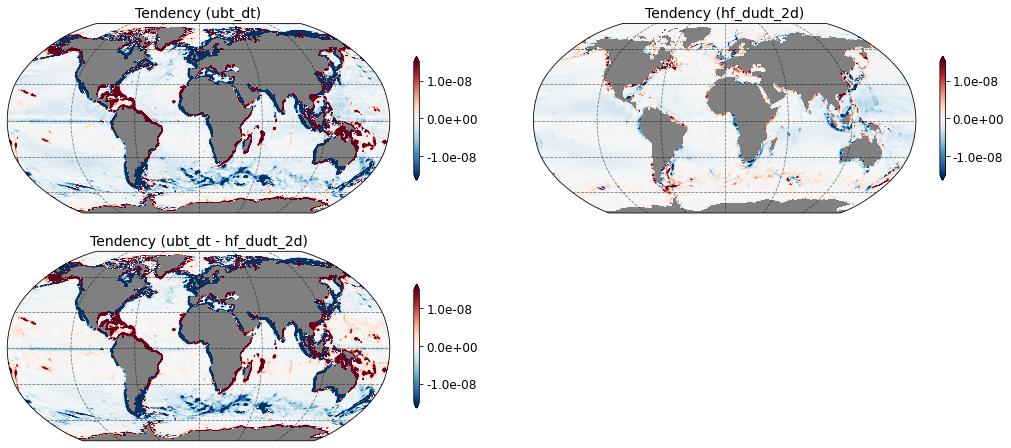

In [11]:
# Difference between barotropic velocity tendency and depth-averaged velocity tendency terms (units are in m/s2)

max_r = 0.15e-5

grid = plt.GridSpec(2, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,8])

ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds_g['hf_dudt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Tendency (hf_dudt_2d)')

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds_g['ubt_dt'] , vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Tendency (ubt_dt)')

ax = fig.add_subplot(grid[1, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds_g['ubt_dt'] - ds_g['hf_dudt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Tendency (ubt_dt - hf_dudt_2d)')

In [14]:
ds.close()
client.close()
cluster.close()